<a href="https://colab.research.google.com/github/zuzannazak/Tangles/blob/main/Tangle_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tangles theoretical intro

##Definitions

Traditional clustering identifies groups of objects that share
certain qualities. Tangles do the converse: they identify
groups of qualities that often occur together. They can
thereby identify and discover types: of behaviour, views,
abilities, dispositions.



We shall make precise the following notions introduced informally so far:

• (potential) features s of (elements v of) V

• specifications →s , ←s of such s

• consistency of specifications

• types (or typical specifications of S)

• tangles

#Tangles example - Polish administrative regions and numeric variables

Data about Polish administrative regions (16) regarding population health.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_excel("/content/drive/MyDrive/STUDIA/Doktorskie/Tangle/test-data.xlsx")
df.head()

,Nazwa wojewodztwa,Oczekiwane trwanie życia w zdrowiu - mężczyźni,Oczekiwane trwanie życia w zdrowiu - kobiety,Lekarze posiadający prawo wykonywania zawodu medycznego na 10 tys. ludności,Powierzchnia gruntów leśnych (ha)
0,DOLNOŚLĄSKIE,59.3,63.1,43.2,28652.24
1,KUJAWSKO-POMORSKIE,59.8,63.5,32.3,53390.76
2,LUBELSKIE,59.4,62.9,42.0,240792.69
3,LUBUSKIE,60.6,64.2,25.3,15003.21
4,ŁÓDZKIE,58.7,62.7,48.3,139044.29


##Naive table search algorythm
**Input:** The separation system S, enumerated as s1, . . . , sn; oracle access to F.

**Output:** For every i ≤ n a list Ti of all F-tangles of {s1, . . . , si}.

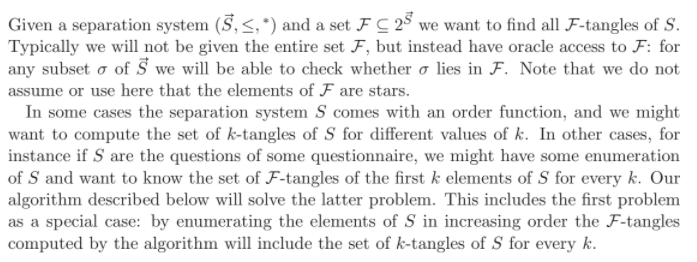